# Factor Backtesting. Here we evaluate the Long Porfoflio of stocks with key metrics as Sharpe Ratio, Return, Volatility, Drawdown with an ability to beat Benchmark(Nifty 50 & Nifty Midcap Index) 

In [38]:
import sys
sys.path.insert(0, "./ffn-master/")
import ffn
import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import json

In [39]:
#***********************This Section is to read from saved file and index*****************
concat_df=pd.read_csv('data/Data_Y_nifty500.csv')
concat_df['Date']= pd.to_datetime(concat_df['Date'])
concat_df=concat_df[concat_df['Date']>='03/03/2011']
concat_df.columns

Index(['Unnamed: 0', 'Company Name', 'Industry', 'Symbol', 'Capitalization',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Share_Turnover', 'Return', 'Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss',
       'Mom_Slope', 'StDev', 'Liquidity', 'Volatility', 'NSE500', 'CAPM_Beta',
       'CAPM_Alpha', 'Sector_Return', 'Sales', 'OPM', 'NetProfit', 'EPSinRs',
       'DividendPayout', 'OtherLiabilities', 'Open_Shares', 'Sales_Growth',
       'EPS_Growth', 'OPM_Growth', 'ROE', 'Leverage', 'BVPS', 'Sale_per_share',
       'EPS in Rs', 'EPS', 'E/P', 'Sales/Price', 'BV/Price', 'PEG',
       'Div/Price', 'Size_Factor', 'Quality', 'Value'],
      dtype='object')

# Treating missing values

In [40]:
concat_df=concat_df.replace([np.inf, -np.inf], np.nan)
column_list=['Share_Turnover','Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss', 'Mom_Slope',
       'StDev', 'Liquidity', 'Volatility','CAPM_Alpha',
       'Sales', 'OPM', 'NetProfit','DividendPayout', 
       'Sales_Growth', 'EPS_Growth', 'OPM_Growth', 'ROE', 'Leverage', 'BVPS',
       'Sale_per_share','EPS', 'E/P', 'Sales/Price', 'BV/Price',
       'PEG', 'Div/Price', 'Size_Factor', 'Quality', 'Value']
for column in column_list:
    concat_df[concat_df[column]==""] = np.NaN
    concat_df[column]=concat_df.groupby('Symbol')[column].fillna(method='bfill')
    concat_df[column]=concat_df.groupby('Symbol')[column].fillna(method='ffill')

# Winsorizing at 1% and 99% levels 

In [41]:
column_list=['Share_Turnover','Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss', 'Mom_Slope',
       'StDev', 'Liquidity', 'Volatility','CAPM_Alpha',
       'Sales', 'OPM', 'NetProfit','DividendPayout', 
       'Sales_Growth', 'EPS_Growth', 'OPM_Growth', 'ROE', 'Leverage', 'BVPS',
       'Sale_per_share','EPS', 'E/P', 'Sales/Price', 'BV/Price',
       'PEG', 'Div/Price', 'Size_Factor', 'Quality', 'Value']
for column in column_list:
    concat_df[column]=np.where(concat_df[column] > concat_df[column].quantile(0.99),concat_df[column].quantile(0.99), concat_df[column])
    concat_df[column]=np.where(concat_df[column] < concat_df[column].quantile(0.01),concat_df[column].quantile(0.01), concat_df[column])

# Scoring/ Ranking the factors to create Long Only Portoflios

In [42]:
column_list=['Share_Turnover','Momentum', 'Mom_Sharpe', 'Mom_Gain_Loss', 'Mom_Slope',
       'StDev', 'Liquidity', 'Volatility','CAPM_Alpha',
       'Sales', 'OPM', 'NetProfit','DividendPayout', 
       'Sales_Growth', 'EPS_Growth', 'OPM_Growth', 'ROE', 'Leverage', 'BVPS',
       'Sale_per_share','EPS', 'E/P', 'Sales/Price', 'BV/Price',
       'PEG', 'Div/Price', 'Size_Factor', 'Quality', 'Value']
for column in column_list:
    concat_df[column]=concat_df.groupby('Date')[column].rank(ascending=1)

# Further filter the Nifty 50 universe based on user specific inputs

In [43]:
screen_data=pd.read_csv('data/Peer_Ticker_nifty500_stand_cleaned.csv')
screen_1=screen_data[screen_data['Debt / Eq'] < 0.33]
screen_2=screen_1[screen_1['Prom. Hold.  %'] > 20]
#screen_3=screen_2[screen_2['ROE  %'] > 15]
#screen_3=screen_3[screen_3['ROA 12M  %'] > 10]
screen_4=screen_2[screen_2['CMP  Rs.'] < 5000]
#screen_4=screen_4[screen_4['CMP  Rs.'] > 50]
screen_4=screen_4['Ticker'].unique().tolist()
len(screen_4)

227

In [44]:
#Apply the custom filter above to further filter the Nifty 50 universe 
concat_df=concat_df[concat_df['Symbol'].isin(screen_4)]
concat_df.groupby('Capitalization')['Symbol'].apply(lambda x:len(x.unique().tolist()))

Capitalization
LARGE        44
MIDCAP       65
SMALLCAP    118
Name: Symbol, dtype: int64

# Create Custom Factors by mixing them like Momentum_Value, Momentum_Std, Momentum_EP etc.

In [45]:
#concat_df['StDev']=concat_df['StDev']/100
concat_df['MomSharpe_Size_EP']=concat_df['Mom_Sharpe']+concat_df['Size_Factor']+concat_df['E/P']
concat_df['Mom_Size']=concat_df['Momentum']+concat_df['Size_Factor']
concat_df['MomSharpe_Size']=concat_df['Mom_Sharpe']+concat_df['Size_Factor']
concat_df['Mom_Std_Sales']=concat_df['Momentum']+concat_df['StDev']+concat_df['Sales_Growth']
concat_df['Mom_EP']=concat_df['Momentum']+concat_df['E/P']
concat_df['Size_EP']=concat_df['Size_Factor']+concat_df['E/P']
concat_df['Vol_Size_EP']=concat_df['Volatility']+concat_df['Size_Factor']+concat_df['E/P']
concat_df['Mom_Size_Sales']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sales_Growth']
concat_df['Mom_Size_Sales_Std']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['StDev']
concat_df['Mom_Size_Std']=concat_df['Momentum']+concat_df['Size_Factor']+concat_df['StDev']
concat_df['Size_Std']=concat_df['Size_Factor']+concat_df['StDev']
concat_df['Mom_Std']=concat_df['Momentum']+concat_df['StDev']
concat_df['Size_Sales_EP']=concat_df['Size_Factor']+concat_df['Sales_Growth']+concat_df['E/P']

# Function to calculate long only portfolio. We can specific rebalancing dates(Weekly=5, Monthly=22, Yearly=250) and Stocks to screen(like top 200, 100, 20 stocks per rebalance date)

In [100]:
def evaluate_Long_Portfolio(concat_df, factor_name, rebalance_period= 5,screen_stock=10):
    #date_rng = pd.date_range(start=concat_df['Date'].min(), end=concat_df['Date'].max(), freq=rebalance_period).tolist()
    date_rng=concat_df["Date"].map(lambda t: t.date()).unique().tolist()[0::rebalance_period]
    concat_df1=concat_df[concat_df['Date'].isin(date_rng)]
    concat_df2=concat_df1#[concat_df1['Capitalization']=='LARGECAP']
    concat_df2=concat_df2.groupby("Date").apply(lambda x: x.nlargest(150,'E/P')).droplevel(1).drop(['Date'],axis=1)
    #concat_df2=concat_df2.groupby("Date").apply(lambda x: x.nlargest(screen_stock,factor_name)).droplevel(1)
   # print("Concat DF2: ", concat_df2.head())
    cap_list=['LARGE','MIDCAP','SMALLCAP']
    def diversified(concat_df2):
        concat_df3=pd.DataFrame()
        for cap in cap_list:
            filt_data=concat_df2[concat_df2['Capitalization']==cap]
            if filt_data.empty:
                print('DataFrame is empty! for Capitalization', cap)
            else:
                filt_data=filt_data.groupby("Date").apply(lambda x: x.nlargest(3,factor_name)).droplevel(1)
                concat_df3=concat_df3.append(filt_data)
        return concat_df3
    #print("Concat DF3:",concat_df3.head())
    concat_df2=diversified(concat_df2)
    screener_out=concat_df2
    concat_df2=concat_df2.reset_index()
    concat_df2=concat_df2[['Date','Symbol',factor_name]]
    concat_df2.reset_index()
    concat_df2['Scaled_Momentum']=concat_df2.groupby('Date')[factor_name].apply(lambda x: x/x.sum())
    concat_df2=concat_df2.reset_index()
    concat_df2=concat_df2.drop([factor_name],axis = 1)
    #print("Concat DF2:",concat_df2.head())
    date_rng1=pd.date_range(start=concat_df2['Date'].min(), end=concat_df2['Date'].max(), freq='1D').tolist()
    date_rng2=concat_df2["Date"].map(lambda t: t.date()).unique().tolist()
    date_rng2=concat_df2["Date"].map(lambda t: t.date()).unique()
    z1=pd.DataFrame()
    for dt1 in date_rng1:
        t1=pd.DataFrame()
        old_date=dt1-pd.DateOffset(days=1)
        #print("Old Date is:", old_date)
        if(dt1 in date_rng2):
            #print("Inside If")
            t1=concat_df2[concat_df2['Date']==dt1]
            t1['Date']=dt1
        else:
            #print("Inside Else")
            t1=z1[z1['Date']==old_date]
            t1['Date']=dt1
        z1=z1.append(t1)
    concat_df5=concat_df[['Symbol', 'Date', 'Return']]
    concat_df5.head()
    concat_df6=z1.merge(concat_df5, how='right', on=['Date','Symbol'])
    concat_df7=pd.DataFrame()
    concat_df7['Mom_Return']=concat_df6.groupby("Date").apply(lambda x: np.sum(x['Scaled_Momentum']*x['Return']))
    concat_df7=concat_df7.loc[~(concat_df7==0).all(axis=1)]
    factor_plot='Plot_'+factor_name
    concat_df7[factor_plot]= (concat_df7['Mom_Return'] + 1).cumprod()
    concat_df7=concat_df7.drop(['Mom_Return'],axis=1)
    plt_file_name='data\\' + factor_plot +'.png'
    concat_df7.plot(y=factor_plot,figsize=(10,10)).get_figure().savefig(plt_file_name)
    return z1, concat_df7, screener_out  

# Function for Backtesting each factor based on BT, FFN Library

In [101]:
out_add=pd.DataFrame()
def create_strategy_data(concat_df,factor_list,rebalance_period= 5,screen_stock=10):
    factor_return_frame=pd.DataFrame()
    for factor_name in factor_list:
        #print("Now processing for factor: ", factor_name)
        z1, factor_return,factor_screen=evaluate_Long_Portfolio(concat_df,factor_name, rebalance_period=rebalance_period,screen_stock=screen_stock)
        factor_return=factor_return.sort_index()
        factor_return.rebase().head()
        factor_return_frame=pd.concat([factor_return_frame,factor_return], axis=1)
        riskfree_rate=0.0002765
        s_equal_weights_factor = bt.Strategy(factor_name, [bt.algos.RunQuarterly(),bt.algos.SelectAll(), bt.algos.WeighEqually(),bt.algos.Rebalance()])
        b_equal_weights_factor= bt.Backtest(s_equal_weights_factor, factor_return)
        result = bt.run(b_equal_weights_factor)
        #print("Done Calculating result for factor: ", factor_name)
        out_add[factor_name]=result.stats[factor_name]
    return out_add,factor_return_frame

# Function for backtesting with parameters like recon dates and screen stocks per date

Momentum
0% [############################# ] 100% | ETA: 00:00:00StDev
0% [############################# ] 100% | ETA: 00:00:00ROE
0% [############################# ] 100% | ETA: 00:00:00Size_Factor
0% [############################# ] 100% | ETA: 00:00:00Quality
0% [############################# ] 100% | ETA: 00:00:00Value
0% [############################# ] 100% | ETA: 00:00:00MomSharpe_Size_EP
0% [############################# ] 100% | ETA: 00:00:00Vol_Size_EP
0% [############################# ] 100% | ETA: 00:00:00Mom_Size
0% [############################# ] 100% | ETA: 00:00:00Size_EP
0% [############################# ] 100% | ETA: 00:00:00

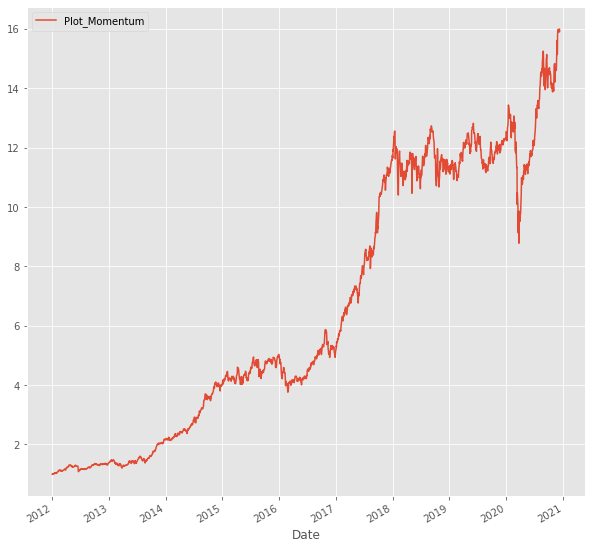

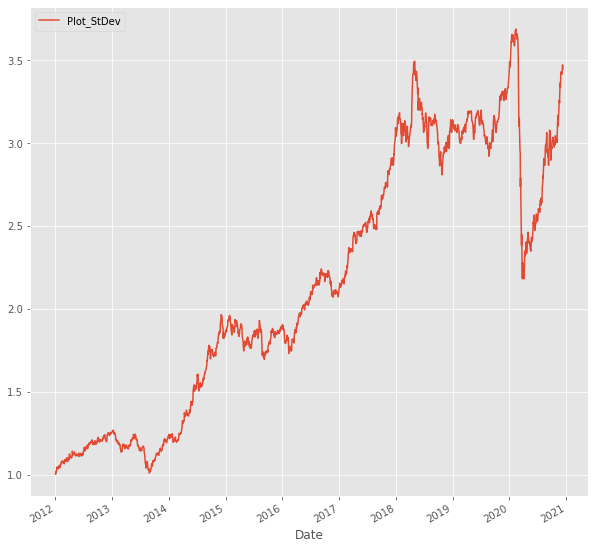

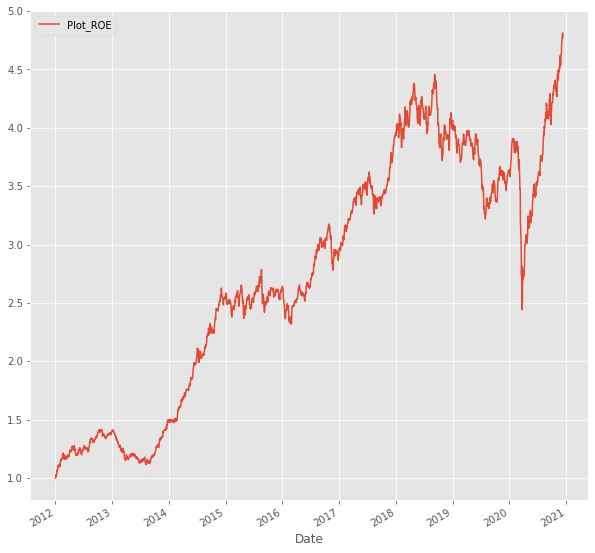

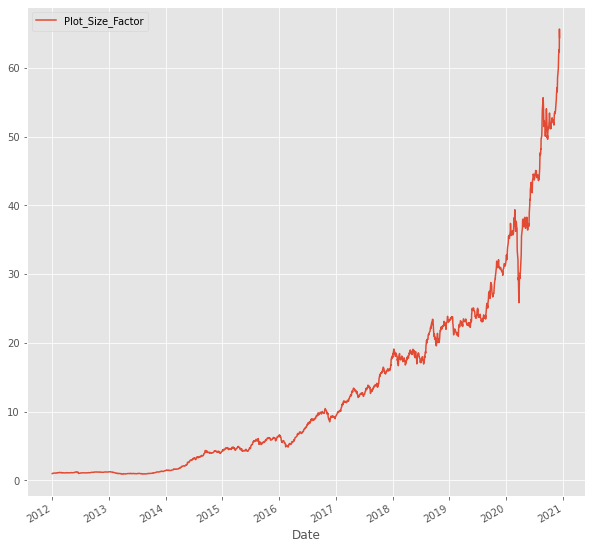

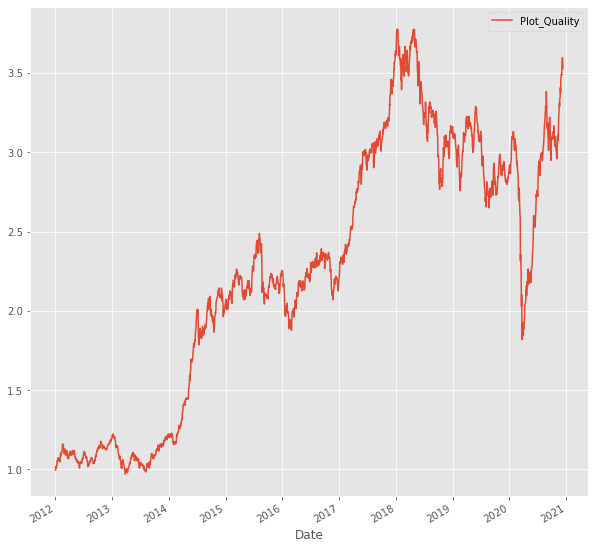

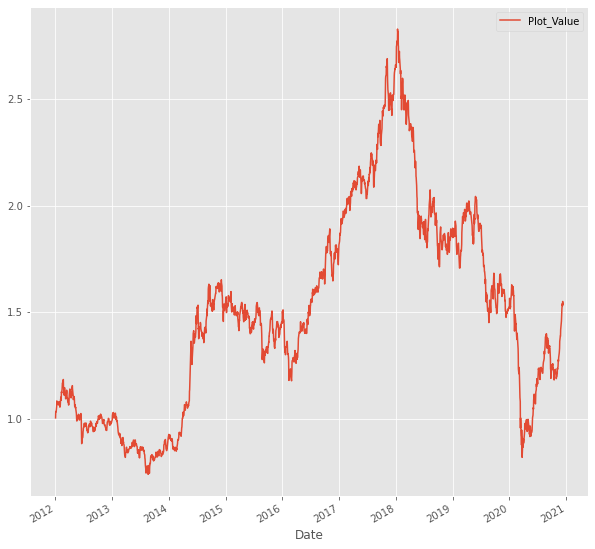

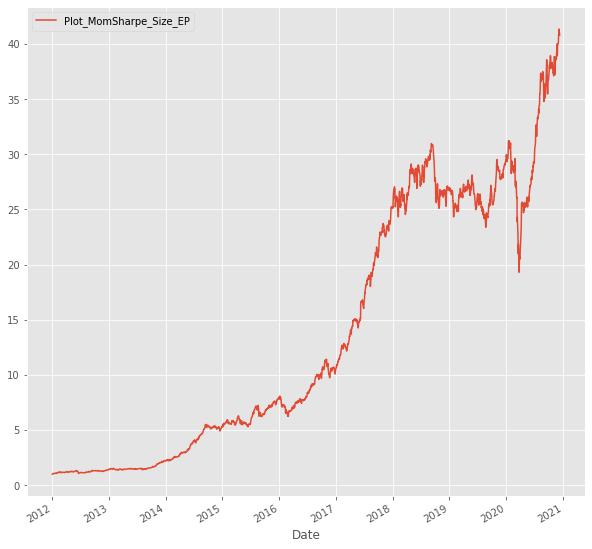

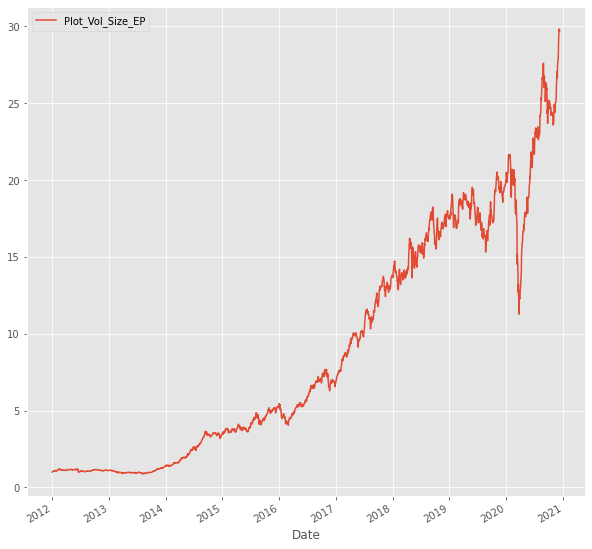

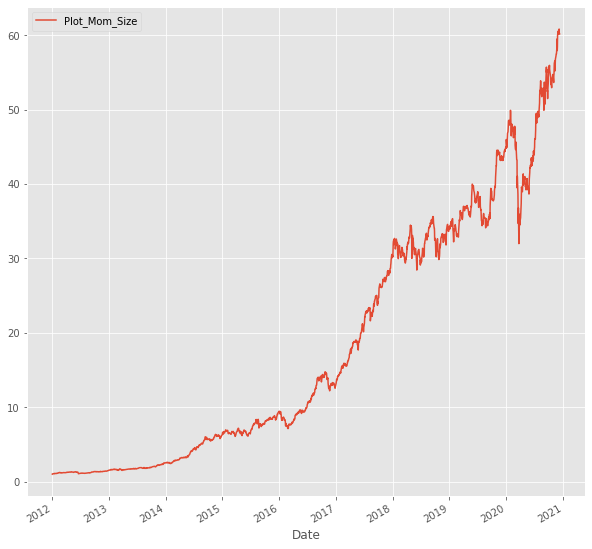

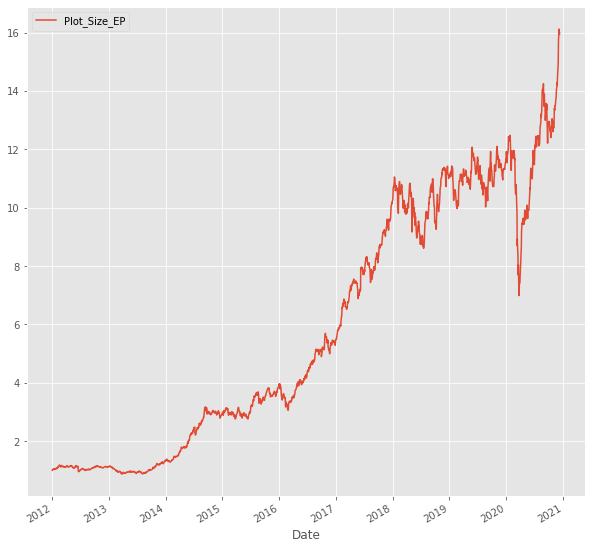

In [103]:
factor_list=['Momentum','StDev','ROE','Size_Factor', 'Quality', 'Value', 'MomSharpe_Size_EP','Vol_Size_EP','Mom_Size', 'Size_EP']
strategy_data,factor_return_frame=create_strategy_data(concat_df,factor_list,rebalance_period= 20,screen_stock=100)
#strategy_data.to_csv('strategy_data.csv')

# Backtesting Nifty 50 Benchmark

Benchmark NIFTY50
0% [############################# ] 100% | ETA: 00:00:00

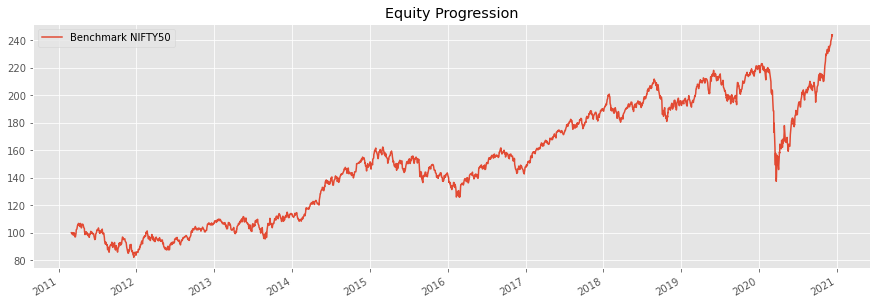

In [52]:
beginning = '2004-06-01'
data_nse50 = bt.get('^NSEI', start=beginning)
data_nse50=data_nse50[data_nse50.index>='3/3/2011']
data_nse50=data_nse50[data_nse50.index<'12/13/2020']
s_nse50 = bt.Strategy('Benchmark NIFTY50', 
                       [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])                    
b_nse50 = bt.Backtest(s_nse50, data_nse50)
result = bt.run(b_nse50)
result.plot()
strategy_data['Benchmark NIFTY50']=result.stats['Benchmark NIFTY50']

# Backtesting Nifty Midcap Benchmark

In [55]:
# Data for Nifty Midcap Benchmark
beginning = '2004-06-01'
data_nsemid100 = bt.get('^CRSMID', start=beginning)
data_nsemid100=data_nsemid100[data_nsemid100.index>='3/3/2011']
data_nsemid100=data_nsemid100[data_nsemid100.index<'12/13/2020']
s_nsemid100 = bt.Strategy('Benchmark NiftyMid', 
                       [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])
                    
b_nsemid100 = bt.Backtest(s_nsemid100, data_nsemid100)
result = bt.run(b_nsemid100)
strategy_data['Benchmark NiftyMid']=result.stats['Benchmark NiftyMid']

Benchmark NiftyMid
0% [############################# ] 100% | ETA: 00:00:00

# Writing all strategy metrics like Sharpe Ratio, Return, Risk, Drawdown etc.

In [56]:
strategy_data.to_csv('data/strategy_data_nifty500.csv')

In [79]:
# Writing Factor Return to test co-rrelation in ALphaLens
factor_return_frame.to_csv('data/Factor_Return.csv')

# Create a Screener to Invest for a specified amount of INR and specific factor

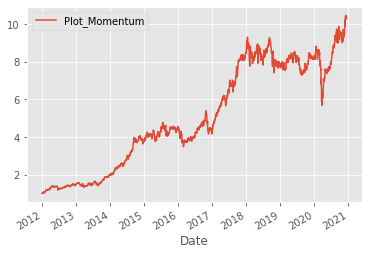

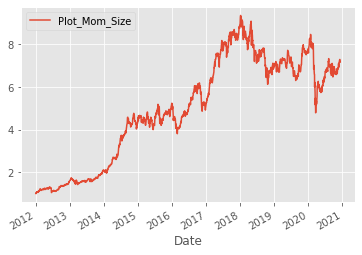

In [98]:
read_nifty=pd.read_csv('NSE_500_Latest.csv')
investment_amount=200000
factor_name_list=['Momentum','Mom_Size']
for factor_name in factor_name_list:
    z1, concat_df7, screener_out = evaluate_Long_Portfolio(concat_df, factor_name, rebalance_period= 1,screen_stock=10)
    screener_out=screener_out[['Symbol',factor_name]]
    screener_out=screener_out.reset_index()
    screener_out[factor_name]=screener_out.groupby('Date')[factor_name].apply(lambda x:x/sum(x))
    screener=screener_out.merge(concat_df[['Symbol','Date','Adj Close']], how='left', on=(['Date','Symbol']))
    screener=screener.merge(read_nifty[['Symbol','Capitalization','Industry']],how='left',on='Symbol')
    screener['Invest_Amount']=screener[factor_name]*investment_amount
    screener['Shares']=(screener['Invest_Amount']/screener['Adj Close']).round()
    filename="data/Screener_"+feature_name+".csv"
    screener.sort_values('Date',ascending=False).to_csv(filename)